In [3]:
import os
import sys
from pathlib import Path
import yaml
from nixtla import NixtlaClient

# Ensure project root is on sys.path for src imports
try:
    ROOT = Path(__file__).resolve().parents[1]
except NameError:
    # __file__ is not defined inside notebooks; fall back to cwd
    cwd = Path.cwd().resolve()
    ROOT = cwd if cwd.name != "notebooks" else cwd.parent
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from src.train.timegpt.timegpt import finetune_timegpt

CONFIG_PATH = ROOT / "configs/configs/timegpt_finetune/timegpt_baseline_config.yaml"
RUN_DIR = ROOT / "results/runs/timegpt_finetune/notebook_run"

api_key = os.environ.get("NIXTLA_API_KEY")
if not api_key:
    raise RuntimeError("Set NIXTLA_API_KEY in your environment before running this notebook.")

print("Using config:", CONFIG_PATH)
print("Run outputs will be saved to:", RUN_DIR)


Using config: C:\Users\jonat\Documents\Code\nocturnal-hypo-gly-prob-forecast\configs\configs\timegpt_finetune\timegpt_baseline_config.yaml
Run outputs will be saved to: C:\Users\jonat\Documents\Code\nocturnal-hypo-gly-prob-forecast\results\runs\timegpt_finetune\notebook_run


In [4]:
with open(CONFIG_PATH, "r") as f:
    config = yaml.safe_load(f)
data_config_preview = config.get("data", {})
id_col = data_config_preview.get("id_col", "id")
time_col = data_config_preview.get("time_col", "datetime")
target_col = data_config_preview.get("target_col", "bg_mM")
config


{'experiment': {'name': 'timegpt_baseline_finetune',
  'description': 'Baseline TimeGPT finetuning on kaggle_brisT1D',
  'tags': ['timegpt', 'kaggle_brisT1D', '5min'],
  'version': '1.0'},
 'model': {'path': 'timegpt-1', 'api_key': None},
 'data': {'source_name': 'kaggle_brisT1D',
  'target_col': 'bg_mM',
  'time_col': 'datetime',
  'id_col': 'id',
  'resolution_min': 5},
 'training': {'forecast_horizon': 12, 'finetune_steps': 10, 'freq': '5min'}}

In [5]:
model_config = config.get("model", {})
data_config = config.get("data", {})
training_config = config.get("training", {})

RUN_DIR.mkdir(parents=True, exist_ok=True)

metrics = finetune_timegpt(
    model_path=model_config.get("path", "timegpt-1"),
    dataset_name=data_config.get("source_name", "kaggle_brisT1D"),
    target_col=data_config.get("target_col", "bg_mM"),
    time_col=data_config.get("time_col", "datetime"),
    id_col=data_config.get("id_col", "id"),
    resolution_min=data_config.get("resolution_min", 5),
    forecast_horizon=training_config.get("forecast_horizon", 12),
    finetune_steps=training_config.get("finetune_steps", 10),
    freq=training_config.get("freq"),
    api_key=api_key,
    run_dir=RUN_DIR,
)
metrics


INFO: Loading processed series from cache...
INFO: Found 9 processed CSV files in c:\Users\jonat\Documents\Code\nocturnal-hypo-gly-prob-forecast\cache\data\kaggle_brisT1D\processed
INFO: Loaded series for 6 patients with 155562 total rows
INFO: Splitting into train/test per series...
INFO: Calling NixtlaClient.forecast with horizon=12, finetune_steps=10, freq=5min
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO: MAE: 0.8883 | RMSE: 1.3472 on 72 rows
INFO: Saved forecast to C:\Users\jonat\Documents\Code\nocturnal-hypo-gly-prob-forecast\results\runs\timegpt_finetune\notebook_run\timegpt_forecast.csv
INFO: Saved metrics to C:\Users\jonat\Documents\Code\nocturnal-hypo-gly-prob-forecast\results\runs\timegpt_finetune\notebook_run\timegpt_metrics.json


{'mae': 0.8883154361111112,
 'mse': 1.8148270954704584,
 'rmse': 1.3471551861127427,
 'count': 72}

In [8]:
import pandas as pd
forecast_path = RUN_DIR / "timegpt_forecast.csv"
if forecast_path.exists():
    pd.read_csv(forecast_path).head()
else:
    print("Forecast file not found at", forecast_path)


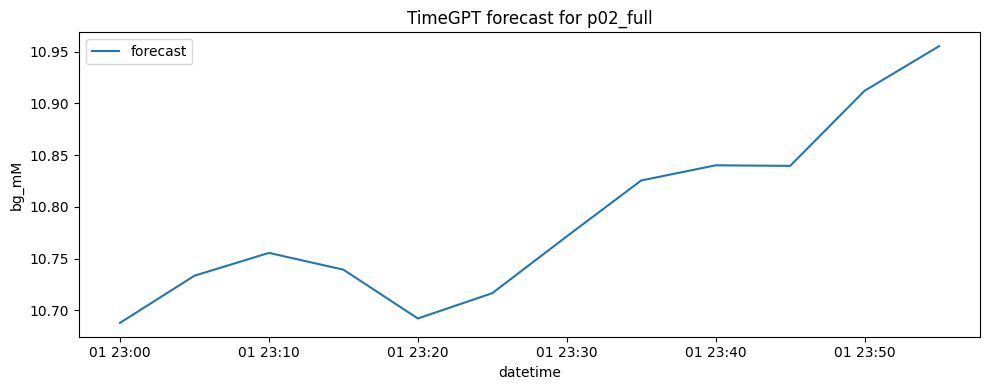

In [10]:
import matplotlib.pyplot as plt

forecast_path = RUN_DIR / "timegpt_forecast.csv"
if not forecast_path.exists():
    print("Forecast file not found at", forecast_path)
else:
    fcst = pd.read_csv(forecast_path)
    if fcst.empty:
        print("Forecast file is empty")
    else:
        id_col = data_config.get("id_col", "id")
        time_col = data_config.get("time_col", "datetime")
        target_col = data_config.get("target_col", "bg_mM")
        first_id = fcst[id_col].iloc[0]
        fcst_subset = fcst[fcst[id_col] == first_id].copy()
        fcst_subset[time_col] = pd.to_datetime(fcst_subset[time_col])
        value_col = fcst_subset.columns[-1]

        plt.figure(figsize=(10, 4))
        plt.plot(fcst_subset[time_col], fcst_subset[value_col], label="forecast")
        plt.title(f"TimeGPT forecast for {first_id}")
        plt.xlabel(time_col)
        plt.ylabel(target_col)
        plt.legend()
        plt.tight_layout()
        plt.show()


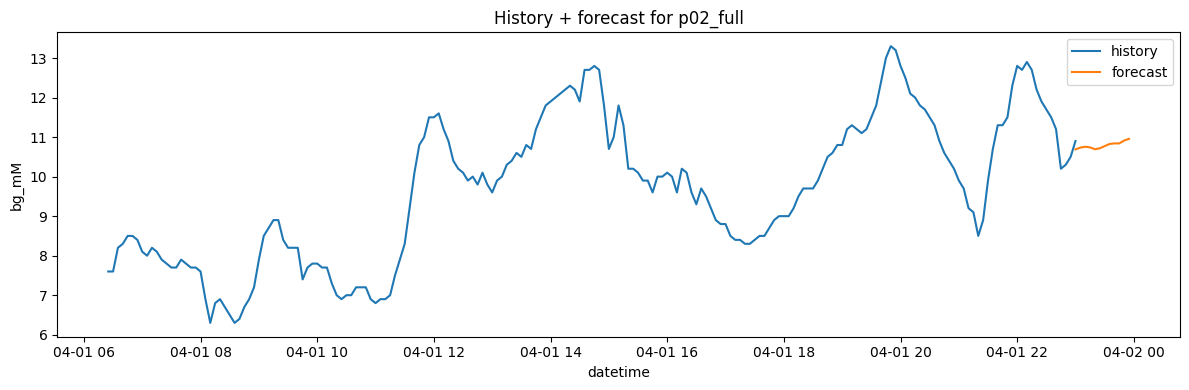

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

forecast_path = RUN_DIR / "timegpt_forecast.csv"
if not forecast_path.exists():
    print("Forecast file not found at", forecast_path)
else:
    fcst = pd.read_csv(forecast_path)
    if fcst.empty:
        print("Forecast file is empty")
    else:
        first_id = fcst[id_col].iloc[0]
        fcst_subset = fcst[fcst[id_col] == first_id].copy()
        fcst_subset[time_col] = pd.to_datetime(fcst_subset[time_col])
        value_col = fcst_subset.columns[-1]
        forecast_start = fcst_subset[time_col].min()

        patient_file = ROOT / "cache" / "data" / data_config.get("source_name", "kaggle_brisT1D") / "processed" / f"{first_id}.csv"
        if not patient_file.exists():
            print("Patient file not found:", patient_file)
        else:
            hist = pd.read_csv(patient_file, index_col=0, parse_dates=True)
            hist = hist.reset_index().rename(columns={"index": time_col})
            hist[time_col] = pd.to_datetime(hist[time_col])
            hist = hist.sort_values(time_col)
            hist_recent = hist[hist[time_col] <= forecast_start].tail(200)

            plt.figure(figsize=(12, 4))
            plt.plot(hist_recent[time_col], hist_recent[target_col], label="history")
            plt.plot(fcst_subset[time_col], fcst_subset[value_col], label="forecast")
            plt.title(f"History + forecast for {first_id}")
            plt.xlabel(time_col)
            plt.ylabel(target_col)
            plt.legend()
            plt.tight_layout()
            plt.show()
